In [1]:
# -*- coding: utf-8 -*-
# Author: Slim Essid
import wave
import matplotlib.pyplot as plt
import numpy as np
from sklearn import decomposition

In [2]:
# -- Read audio data ----------------------------------------------------------
def wavread(filename):
    """Read .wav file"""
    wf = wave.open(filename)
    s = np.fromstring(wf.readframes(wf.getnframes()), dtype=np.int16)
    wf.close()
    return s
def wavwrite(filename, s, nchannels=1):
    """Write .wav file"""
    wf = wave.open(filename, 'wb')
    wf.setnchannels(nchannels)
    wf.setsampwidth(2)
    wf.setframerate(32000)
    s = s / np.max(np.abs(s)) * 2 ** 14 # normalise arbitrarily
    wf.writeframes(s.astype(np.int16).tostring())
    wf.close()
   

In [3]:
s1 = wavread('./snd/es02.wav')
s2 = wavread('./snd/si01.wav')
# -- Create stereo mix --------------------------------------------------------
nsmp = min(len(s1), len(s2))
s1 = s1[:nsmp]
s2 = s2[:nsmp]
S = np.c_[s1, s2]
# Mixing matrix
A = np.array([[0.6, 0.5],
              [0.4, 0.5]])
# Do the mix
X = S.dot(A)
# Write mix file
x = np.zeros(2 * nsmp)
x[::2] = X[:, 0]
x[1::2] = X[:, 1]
wavwrite('./snd/mix.wav', x, nchannels=2)
# -- ICA source separation ----------------------------------------------------

### Question n°2

In [25]:
# lire la soure mélangée
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xindep = np.zeros((s1.shape[0],2))
sourcesmixed = wavread('./snd/mix.wav')
Xindep[:, 0] = (sourcesmixed[::2]-sourcesmixed[::2].mean())/sourcesmixed[::2].std()
Xindep[:, 1] = (sourcesmixed[1::2]-sourcesmixed[1::2].mean())/sourcesmixed[1::2].std()
# extraction
decompsources = decomposition.FastICA(n_components=2).fit_transform(Xindep)
wavwrite('./snd/channel1.wav', decompsources[:,0], nchannels=1)
wavwrite('./snd/channel2.wav', decompsources[:,1], nchannels=1)


In [26]:
import IPython.display as ipd
ipd.Audio('./snd/channel1.wav')



In [27]:
import IPython.display as ipd
ipd.Audio('./snd/channel2.wav')

In [28]:
import seaborn # optional
import matplotlib.pyplot as plt
import librosa.display

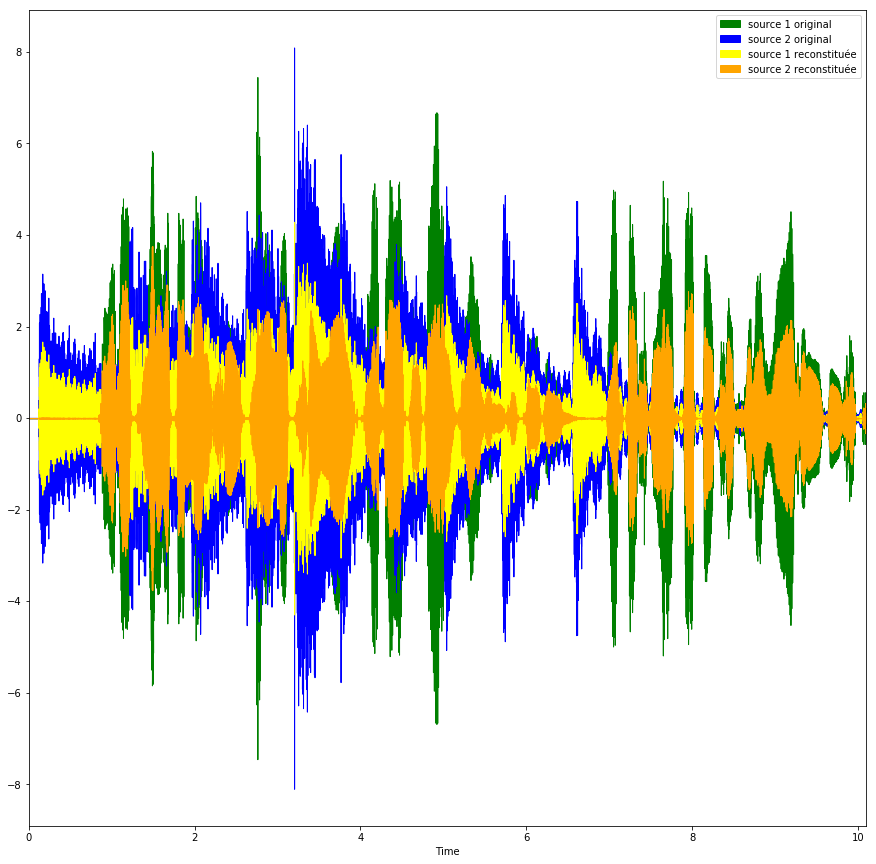

In [36]:
%matplotlib inline
plt.figure(figsize=(15, 15))
librosa.display.waveplot((s1 - s1.mean()) / s1.std(),
                         color='green', label='source 1 original')
librosa.display.waveplot((s2 - s2.mean()) / s2.std(),
                         color='blue', label='source 2 original')
librosa.display.waveplot(
    decompsources[:, 0] * 250, color='yellow', label='source 1 reconstituée')
librosa.display.waveplot(
    decompsources[:, 1] * 250, color='orange', label='source 2 reconstituée')
plt.legend()
plt.show()

Dataset consists of 400 faces
2061 negative-valued pixels
2773 negative-valued pixels
2630 negative-valued pixels
1422 negative-valued pixels
1242 negative-valued pixels
1004 negative-valued pixels
2049 negative-valued pixels
1580 negative-valued pixels
1387 negative-valued pixels
3819 negative-valued pixels
Extracting the top 10 Eigenfaces - PCA...
done in 1.151s
3998 negative-valued pixels
2078 negative-valued pixels
1967 negative-valued pixels
1862 negative-valued pixels
2261 negative-valued pixels
1924 negative-valued pixels
1951 negative-valued pixels
1883 negative-valued pixels
2221 negative-valued pixels
2127 negative-valued pixels
done in 4.440s


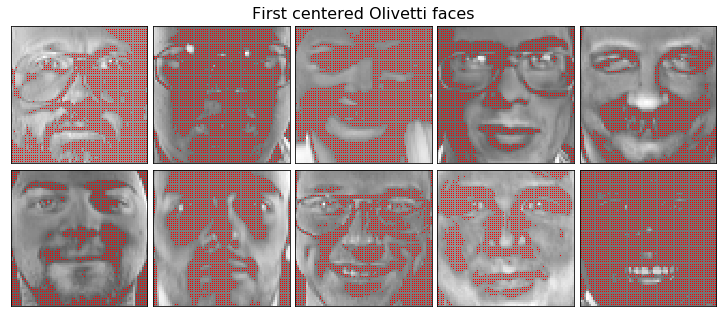

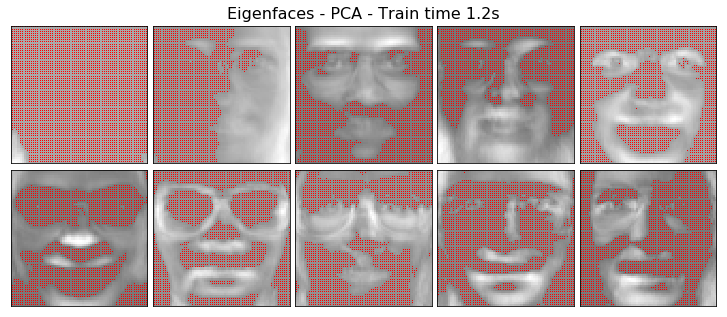

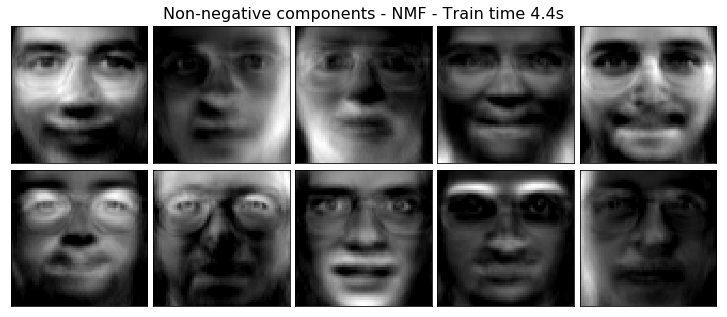

In [37]:
#  License: BSD
#  -*- coding: utf-8 -*-

#  Authors: Vlad Niculae, Alexandre Gramfort, Slim Essid


from time import time

import matplotlib.pyplot as plt

import numpy as np
from numpy.random import RandomState
from sklearn.model_selection import cross_val_score
from sklearn import decomposition
from sklearn.datasets import fetch_olivetti_faces
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# -- Prepare data and define utility functions --------------------------------

n_row, n_col = 2, 5
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0, dtype=np.float64)

print("Dataset consists of %d faces" % n_samples)


def plot_gallery(title, images):
    """Plot images as gallery"""
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        comp = comp.reshape(image_shape)
        vmax = comp.max()
        vmin = comp.min()
        dmy = np.nonzero(comp < 0)
        if len(dmy[0]) > 0:
            yz, xz = dmy
        comp[comp < 0] = 0

        plt.imshow(comp, cmap=plt.cm.gray, vmax=vmax, vmin=vmin)

        if len(dmy[0]) > 0:
            plt.plot(xz, yz, 'r,')
            print(len(dmy[0]), "negative-valued pixels")

        plt.xticks(())
        plt.yticks(())

    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

# Plot a sample of the input data
plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# -- Decomposition methods ----------------------------------------------------

# List of the different estimators and whether to center the data

estimators = [
    ('pca', 'Eigenfaces - PCA',
     decomposition.PCA(n_components=n_components, whiten=True),
     True),

    ('nmf', 'Non-negative components - NMF',
     decomposition.NMF(n_components=n_components,
                       init=None, tol=1e-6, max_iter=1000),
     False)
]

# -- Transform and classify ---------------------------------------------------

labels = dataset.target
X = faces
X_ = faces_centered

for shortname, name, estimator, center in estimators:
    if shortname != 'nmf':
        print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()

    data = X
    if center:
        data = X_

    data = estimator.fit_transform(data)

    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)

    components_ = estimator.components_

    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])
plt.show()

### PCA vs NMF Question n°1


La pca est plus rapide mais pas ineterprtable les pixels rouges étant des pixels négatifs, les deux premiers visages ne sont pas reconnaissables. La NMF est plus lente mais génére un résultat interpretable. De plus la PCA prend en entrée des visages centrés ou on a enlevé la moyenne des pixels de l'échantillon.

### Evaluation de performance

In [13]:
#nombre de visages different
print(len(np.unique(labels, return_counts=True)[0]))
#repartiton des classes
print(np.unique(labels, return_counts=True)[1])



40
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]


In [42]:
# -- Transform and classify ---------------------------------------------------

labels = dataset.target
ScorePCA = np.empty(40, dtype=float)
ScoreNMF = np.empty(40, dtype=float)


for n_components in range(1, 41):
    X = faces.copy()
    X_ = faces_centered.copy()
    estimatorNMF = decomposition.NMF(n_components=n_components,
                                     init=None, tol=1e-6, max_iter=1000)
    estimatorPCA = decomposition.PCA(
        n_components=n_components, whiten=True)

    X_ = estimatorPCA.fit_transform(X_)
    X = estimatorNMF.fit_transform(X)

    clf = LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                                     solver='svd', store_covariance=False, tol=0.0001)

    ScorePCA[n_components -
             1] = cross_val_score(clf, X_, labels, cv=10, n_jobs=-1).mean()

    ScoreNMF[n_components -
             1] = cross_val_score(clf, X, labels, cv=10, n_jobs=-1).mean()

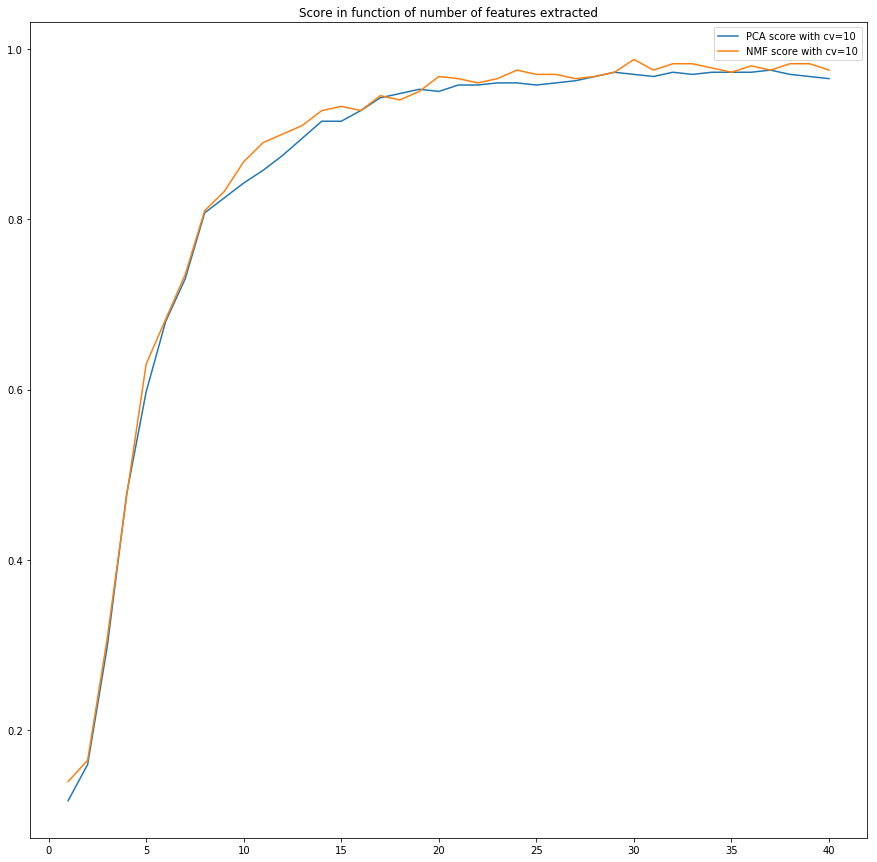

In [43]:
plt.figure(figsize=(15, 15))
plt.plot(range(1, 41), ScorePCA, label='PCA score with cv=10')
plt.plot(range(1, 41), ScoreNMF, label='NMF score with cv=10')
plt.title('Score in function of number of features extracted')
plt.legend()
plt.show()

In [1]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_topics = 10
n_top_words = 20


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data[:n_samples]
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Fit the NMF model
print("Fitting the NMF model with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Loading dataset...
done in 18.826s.
Extracting tf-idf features for NMF...
done in 0.783s.
Extracting tf features for LDA...
done in 0.313s.
Fitting the NMF model with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.984s.

Topics in NMF model:
Topic #0:
just people don think like know time good make way really say right ve want did ll new use years
Topic #1:
windows use dos using window program os drivers application help software pc running ms screen files version card code work
Topic #2:
god jesus bible faith christian christ christians does heaven sin believe lord life church mary atheism belief human love religion
Topic #3:
thanks know does mail advance hi info interested email anybody looking card help like appreciated information send list video need
Topic #4:
car cars tires miles 00 new engine insurance price condition oil power speed good 000 brake year models used bought
Topic #5:
edu soon com send university internet mit ftp mail cc pub article information hop

/home/joseph/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


done in 4.133s.

Topics in LDA model:
Topic #0:
edu com mail send graphics ftp pub available contact university list faq ca information cs 1993 program sun uk mit
Topic #1:
don like just know think ve way use right good going make sure ll point got need really time doesn
Topic #2:
christian think atheism faith pittsburgh new bible radio games alt lot just religion like book read play time subject believe
Topic #3:
drive disk windows thanks use card drives hard version pc software file using scsi help does new dos controller 16
Topic #4:
hiv health aids disease april medical care research 1993 light information study national service test led 10 page new drug
Topic #5:
god people does just good don jesus say israel way life know true fact time law want believe make think
Topic #6:
55 10 11 18 15 team game 19 period play 23 12 13 flyers 20 25 22 17 24 16
Topic #7:
car year just cars new engine like bike good oil insurance better tires 000 thing speed model brake driving performance
Topic

### On voit que grace au TfIdf on a une pas trop mauvaise approximation des termes les plus determinans, ceux que l'on voit en faible quantité dans plusieurs document differents. 